In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import rankdata, mannwhitneyu,  chisquare
import seaborn as sns

In [3]:
# Preamble
sns.set_context("paper", font_scale=2)

In [4]:
# Load questions data
df_questions = pd.read_json("export_questions.jsonl", lines=True)
df_questions.rename(columns={"questionId": "question_id", "reference": "question"}, inplace=True)
df_questions["candidate_id"] = [[0, 1, 2, 3]] * len(df_questions)
df_questions["candidate_votes"] = df_questions.apply(lambda row: [int(c["voting"]) for c in row["candidates"]], axis=1)
df_questions["candidate_votes_rank"] = df_questions.apply(
    lambda row: rankdata([-v for v in row["candidate_votes"]], method="ordinal"), axis=1)
df_questions = df_questions.explode(["candidate_id", "candidates", "candidate_votes_rank", "candidate_votes"])


def get_candidate_type(row):
    if row["candidates"]["isAcceptedAnswer"]:
        return "accepted"
    elif row["candidates"]["isGenerated"]:
        return "generated"
    else:
        return "standard"


df_questions["candidate_type"] = df_questions.apply(lambda row: get_candidate_type(row), axis=1)
df_questions["candidate"] = df_questions.apply(lambda row: row["candidates"]["candidate"], axis=1)
df_questions["candidate_len"] = df_questions["candidate"].apply(lambda x: len(x))

df_questions = df_questions[
    ["question_id", "question", "candidate_id", "candidate_type", "candidate_votes_rank", "candidate_votes",
     "candidate"]]

In [5]:
# Load rankings data
df_rankings = pd.read_json("rankings-4P.jsonl", lines=True)
df_rankings.rename(columns={"questionId": "question_id"}, inplace=True)


def extract_sorted_ranks(ranking_dict):
    result = {}
    for person, entries in ranking_dict.items():
        sorted_entries = sorted(entries, key=lambda x: x['id'])
        result[person] = [entry['rank'] for entry in sorted_entries]
    return result


# Apply the extraction
expanded = df_rankings['rankings'].apply(extract_sorted_ranks)

# Turn the dict into a dataframe (one row per questionid)
expanded_df = pd.DataFrame(expanded.tolist())

# Combine with the original questionid
raw_data = pd.concat([df_rankings['question_id'], expanded_df], axis=1)
raw_data["candidate_id"] = [[0, 1, 2, 3]] * len(raw_data)
raw_data = raw_data[["question_id", "candidate_id", "person1", "person2", "person3", "person4"]]
raw_data = raw_data.explode(["candidate_id", "person1", "person2", "person3", "person4"])

raw_data = pd.merge(raw_data, df_questions[["question_id", "candidate_id", "candidate_type", "candidate_votes_rank", "candidate_votes"]],
                    on=["question_id", "candidate_id"], how="inner")
raw_data = pd.melt(raw_data, id_vars=["question_id", "candidate_id", "candidate_type", "candidate_votes_rank", "candidate_votes"],
                   value_vars=["person1", "person2", "person3", "person4"], var_name="person",
                   value_name="candidate_person_rank")
raw_data["candidate_person_rank"] = raw_data["candidate_person_rank"].astype(int) + 1 # add 1 to all human assigned ranks to make the range 1-4
raw_data["candidate_votes"] = raw_data["candidate_votes"].astype(int)

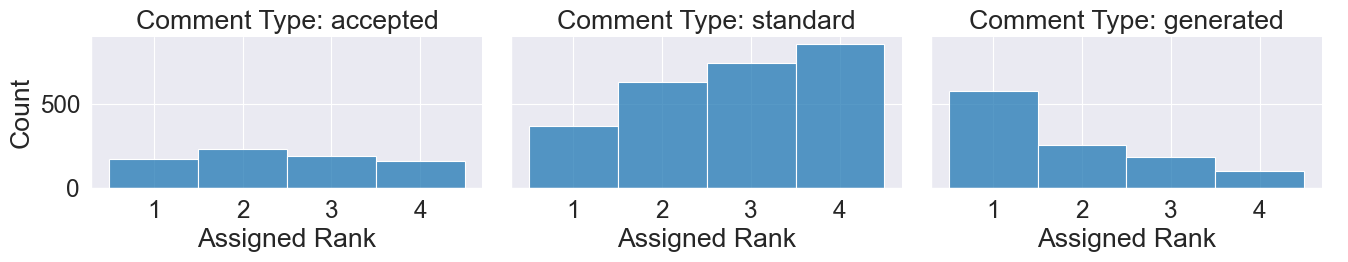

In [6]:
# Plot ranking distributions for different comment types
g = sns.FacetGrid(raw_data, col='candidate_type', col_wrap=3, aspect=1.5, sharex=True, sharey=True)

g.map(sns.histplot, 'candidate_person_rank', discrete=True)

g.add_legend()
g.set_titles("Comment Type: {col_name}")
g.set_axis_labels("Assigned Rank", "Count")

plt.tight_layout()
plt.savefig("commenttype_vs_humanrank.pdf")
plt.show()

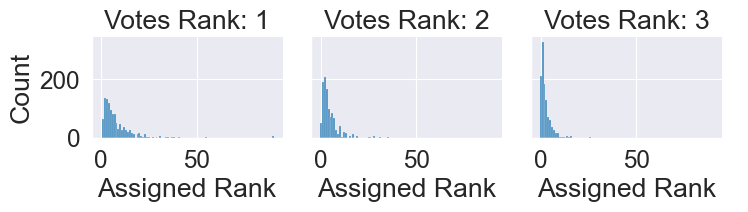

In [7]:
# Plot number of votes distributions for different voting ranks
g = sns.FacetGrid(raw_data.loc[raw_data["candidate_votes_rank"]<4], col='candidate_votes_rank', col_wrap=3, height=2.5, sharex=True, sharey=True)

g.map(sns.histplot, 'candidate_votes', discrete=True)

g.add_legend()
g.set_titles("Votes Rank: {col_name}")
g.set_axis_labels("Assigned Rank", "Count")

plt.tight_layout()
plt.savefig("votesrank_vs_votes.pdf")
plt.show()


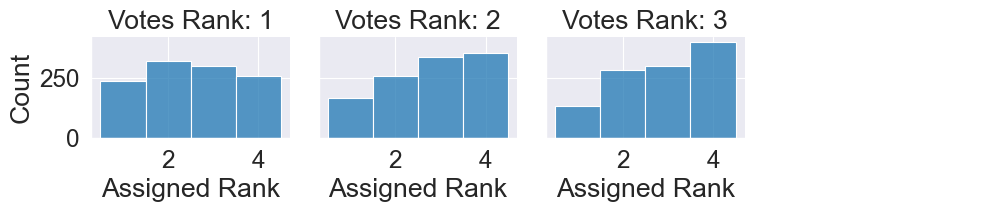

In [8]:
# Plot ranking distributions for different voting ranks
g = sns.FacetGrid(raw_data.loc[raw_data["candidate_votes_rank"] < 4], col='candidate_votes_rank', col_wrap=4, height=2.5, sharex=True, sharey=True)

g.map(sns.histplot, 'candidate_person_rank', discrete=True)

g.add_legend()
g.set_titles("Votes Rank: {col_name}")
g.set_axis_labels("Assigned Rank", "Count")

plt.tight_layout()
plt.savefig("votesrank_vs_rank.pdf")
plt.show()

In [9]:
# Check if distribution of assigned ranks with particular comment type differ significantly
def significance_test_types_rank_is_lower(type1, type2):
    return mannwhitneyu(raw_data.loc[raw_data["candidate_type"] == type1]["candidate_person_rank"],
                        raw_data.loc[raw_data["candidate_type"] == type2]["candidate_person_rank"],
                        alternative="less")


# Check if distribution of assigned ranks with particular platform voting rank differ significantly
def significance_test_votesrank_rank_is_lower(votes_rank1, votes_rank2):
    return mannwhitneyu(raw_data.loc[raw_data["candidate_votes_rank"] == votes_rank1]["candidate_person_rank"],
                        raw_data.loc[raw_data["candidate_votes_rank"] == votes_rank2]["candidate_person_rank"],
                        alternative="less")

print(significance_test_types_rank_is_lower("accepted", "standard")) # significant
print(significance_test_types_rank_is_lower("generated", "standard")) # significant

print(significance_test_votesrank_rank_is_lower(1, 2)) # significant
print(significance_test_votesrank_rank_is_lower(1, 3)) # significant
print(significance_test_votesrank_rank_is_lower(2, 3)) # not significant at alpha 0.01

print(raw_data.loc[raw_data["candidate_votes_rank"] == 1]["candidate_votes"].median())
print(raw_data.loc[raw_data["candidate_votes_rank"] == 2]["candidate_votes"].median())
print(raw_data.loc[raw_data["candidate_votes_rank"] == 3]["candidate_votes"].median())

# In terms of votes, the difference in medians between the first and second ranked candidates is three
# times as large as the difference between second and third ranked candidates
# This likely explains why our human assigned ranks are not statistically consistent
# Presumably, for a large enough number of judges, it would also match

MannwhitneyuResult(statistic=792336.0, pvalue=1.5890500320724207e-16)
MannwhitneyuResult(statistic=750688.0, pvalue=2.2514096179116907e-128)
MannwhitneyuResult(statistic=535857.5, pvalue=1.729255665132677e-09)
MannwhitneyuResult(statistic=511023.5, pvalue=1.4165765433095105e-14)
MannwhitneyuResult(statistic=597019.5, pvalue=0.039289085567603924)
6.0
3.0
2.0


In [10]:
# Make table with pairwise tests for comment types
types = ["accepted", "standard", "generated"]
significance_df = pd.DataFrame(index = types, columns=types)
for v1 in types:
    for v2 in types:
        if v1 == v2:
            significance_df.loc[v1, v2] = "-"
            continue
        stat = significance_test_types_rank_is_lower(v1, v2)
        significance_df.loc[v1, v2] = f"{stat.pvalue:.2e}"
#significance_df.to_latex()
print(significance_df)

           accepted   standard generated
accepted          -   1.59e-16  1.00e+00
standard   1.00e+00          -  1.00e+00
generated  1.55e-36  2.25e-128         -


In [11]:
# Make table with pairwise tests for voting ranks
vote_ranks = [1,2,3,4]
significance_df = pd.DataFrame(index = vote_ranks, columns=vote_ranks)
for v1 in vote_ranks:
    for v2 in vote_ranks:
        if v1 == v2:
            significance_df.loc[v1, v2] = "-"
            continue
        stat = significance_test_votesrank_rank_is_lower(v1, v2)
        significance_df.loc[v1, v2] = f"{stat.pvalue:.2e}"
#significance_df.to_latex()
print(significance_df)

          1         2          3         4
1         -  1.73e-09   1.42e-14  1.00e+00
2  1.00e+00         -   3.93e-02  1.00e+00
3  1.00e+00  9.61e-01          -  1.00e+00
4  5.22e-53  4.97e-90  2.52e-103         -


In [12]:
# Test that ranks assigned generated comments are not random (uniformly distributed)

ranks = raw_data.loc[raw_data["candidate_type"] == "generated"]["candidate_person_rank"].to_list()

# Count frequency of each rank
rank_counts = pd.Series(ranks).value_counts().sort_index()
observed = rank_counts.values
print(observed)

# Expected: uniform distribution across all rank levels
expected = [sum(observed) / len(observed)] * len(observed)
print(expected)

stat, p = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-squared: {stat:.3f}, p-value: {p:.4f}")

[576 256 182 102]
[279.0, 279.0, 279.0, 279.0]
Chi-squared: 464.072, p-value: 0.0000
